In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
PATH=os.getcwd()

mod="CAE"
rep='wvlt'

trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'trainResults.pkl'
testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'testResults.pkl'
trainRes=pd.read_pickle(trainRes_path)
testRes=pd.read_pickle(testRes_path)

results=pd.DataFrame({utter:{'test_loss':0, 'test_acc':0, 'tstSpk_data':{}} for utter in testRes.columns})
div=max(testRes.index)[0]+1

for item in testRes:
    for index in testRes.index:
        if index[1] == 'tstSpk_data':
            results[item][index[1]].update(testRes[item][index])
        else:
            results[item][index[1]]+=testRes[item][index]/div


In [10]:
num_itrs

4

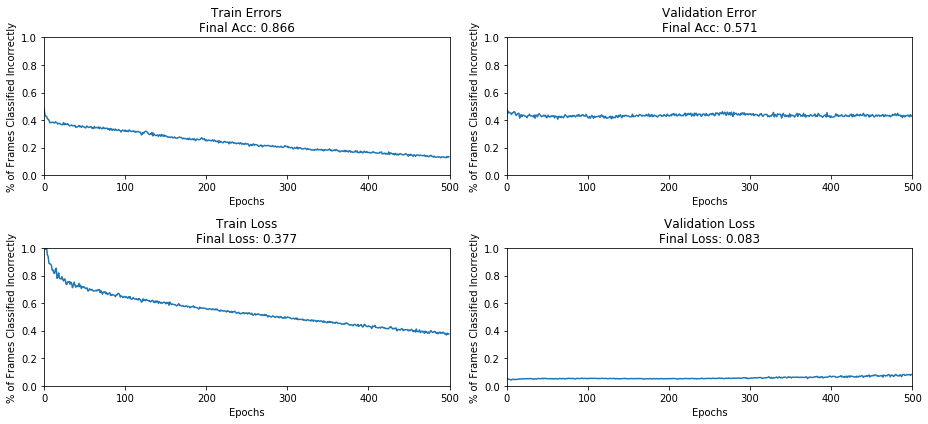

In [11]:
train_acc=0
val_acc=0
train_loss=0
val_loss=0
num_itrs=trainRes.index[-1][0]+1

for i in range(num_itrs):
    train_acc+=trainRes['train_acc'][i][0]/num_itrs
    val_acc+=trainRes['val_acc'][i][0]/num_itrs
    train_loss+=trainRes['train_loss'][i][0]/num_itrs
    val_loss+=trainRes['val_loss'][i][0]/num_itrs
    
fig,ax=plt.subplots(2,2,figsize=(13, 6))

ax[0][0].plot(1-train_acc)
ax[0][0].set_title("Train Errors\nFinal Acc: "+str(np.round(train_acc.iloc[-1],3)))
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("% of Frames Classified Incorrectly")
ax[0][0].set_xlim([0,train_acc.size])
ax[0][0].set_ylim([0,1])

ax[0][1].plot(1-val_acc)
ax[0][1].set_title("Validation Error\nFinal Acc: "+str(np.round(val_acc.iloc[-1],3)))
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("% of Frames Classified Incorrectly")
ax[0][1].set_xlim([0,train_acc.size])
ax[0][1].set_ylim([0,1])

ax[1][0].plot(train_loss)
ax[1][0].set_title("Train Loss\nFinal Loss: "+str(np.round(train_loss.iloc[-1],3)))
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("% of Frames Classified Incorrectly")
ax[1][0].set_xlim([0,train_acc.size])
ax[1][0].set_ylim([0,1])

ax[1][1].plot(val_loss)
ax[1][1].set_title("Validation Loss\nFinal Loss: "+str(np.round(val_loss.iloc[-1],3)))
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("% of Frames Classified Incorrectly")
ax[1][1].set_xlim([0,train_acc.size])
ax[1][1].set_ylim([0,1])

plt.tight_layout()

In [4]:
results

,pataka
test_acc,0.6
test_loss,1.10286
tstSpk_data,"{48: [[0.99966097, 0.00033899496], [0.71813846..."


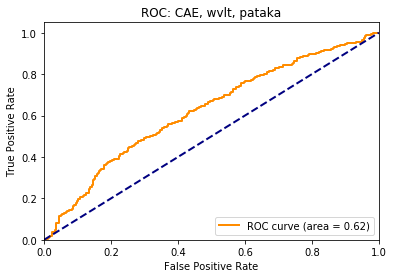

In [5]:
"""
Plotting the ROC and calculating the AUC for all binary classification scores output by the DNN for each speech frame.
"""
num_fr=0
utter='pataka'
for key in results[utter]['tstSpk_data'].keys():
    num_fr+=len(results[utter]['tstSpk_data'][key])
y_score=np.zeros((num_fr,2))
y_test=np.zeros((num_fr,2))

itr=0
for item in results:
    for key,arr in results[item]['tstSpk_data'].items():                
        y_score[itr:itr+len(arr),:]=arr
        if key<50:
            y_test[itr:itr+len(arr),:]=np.vstack((np.ones(len(arr)),np.zeros(len(arr)))).T
        if key>=50:
            y_test[itr:itr+len(arr),:]=np.vstack((np.zeros(len(arr)),np.ones(len(arr)))).T
        itr+=len(arr)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: '+mod+", "+rep+", "+utter)
plt.legend(loc="lower right")
plt.show()

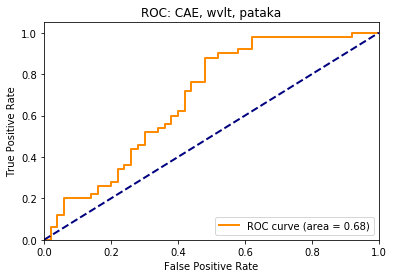

In [6]:
"""
Plotting the ROC and AUC. Now taking the median difference of output probabilities for a given speaker 
(averaged over all frames).
"""
y_score=np.zeros(100)
y_test=np.zeros(100)
test_acc=0
pd_acc=0
hc_acc=0
for item in results:
    for itr,(key,arr) in enumerate(zip(results[item]['tstSpk_data'].keys(),results[item]['tstSpk_data'].values())):                
        y_score[itr]=np.median(arr[:,0]-arr[:,1])
        if key<50:
            y_test[itr]=1
            if y_score[itr]>=0:
                pd_acc+=1
        if key>=50:
            y_test[itr]=0
            if y_score[itr]<=0:
                hc_acc+=1

test_acc=(pd_acc+hc_acc)*.01

fpr = dict()
tpr = dict()
roc_auc = dict()
utter='pataka'
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
plt.figure()
lw = 2
mgc=1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: '+mod+", "+rep+", "+utter)
plt.legend(loc="lower right")


plt.show()